In [1]:
%pylab inline

pylab.rcParams['figure.figsize'] = (6, 6)

import math
import cmath          # math functions for complex numbers
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm

import scipy
import scipy.stats
import pandas as pd

from astropy.io import fits
import os.path

import ipywidgets
from ipywidgets import interact

import sys
sys.path.append("/Users/jdecock/git/pub/jdhp-sap/sap-cta-data-pipeline/datapipe")
import datapipe
import datapipe.denoising.wavelets_mrfilter as mrfilter
sys.path.append("/Users/jdecock/git/pub/jdhp-sap/sap-cta-data-pipeline/utils")
import common_functions as common

/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/PIL/Image.py:85: RuntimeWarning: The _imaging extension was built for another  version of Pillow or PIL
  warnings.warn(str(v), RuntimeWarning)
/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/PIL/Image.py:85: RuntimeWarning: The _imaging extension was built for another  version of Pillow or PIL
  warnings.warn(str(v), RuntimeWarning)


Populating the interactive namespace from numpy and matplotlib


/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/pytz/__init__.py:29: UserWarning: Module argparse was already imported from /Users/jdecock/anaconda/envs/cta/lib/python3.5/argparse.py, but /Users/jdecock/.local/lib/python3.5/site-packages/argparse-1.1-py3.5.egg is being added to sys.path
  from pkg_resources import resource_stream
/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/PIL/Image.py:85: RuntimeWarning: The _imaging extension was built for another  version of Pillow or PIL
  warnings.warn(str(v), RuntimeWarning)


**TODO**:
* charge loss
* threshold
* spellcheck

## Introduction

###  Context

On travaille sur des images provenant de simulations montecarlo de telescopes gamma (~100 GeV to ~300 TeV)

Exemple:
<img src="./figs/image31.gif" width="50%"></img>

Processus:
1. nettoyer l'image (suppression du bruit electronique et du NSB)
2. déterminer l'axe de la gerbe gamma sur l'image
3. par stereoscopie determiner l'origine de la gerbe

|                                                  |                                                  |
| ------------------------------------------------ | ------------------------------------------------ |
| <img src="./figs/image30.png" width="90%"></img> | <img src="./figs/image32.png" width="90%"></img> |
| <img src="./figs/image33.png" width="90%"></img> | <img src="./figs/Arrayscheme2_x.png" width="90%"></img> |


### Image types

#### FlashCam telescopes: 1764 (hexagonal) pixels

<img src="./figs/geom_3_flashcam.png" width="40%">

#### ASTRI telescopes: 2368 (rectangular) pixels

<img src="./figs/geom_4_astri.png" width="40%">

#### and others...

...

### Images I use so far

- Cropped images from Astri telescopes => 40x40 pixels
- Set of ~15000 images

<img src="./figs/geom_4_astri_crop3.svg" width="60%">

### Cleaning algorithm reference

The "Tailcut clean" algorithm:
- Keep pixels above a given threshold (10 PE)
- Keep some neighbors of these selected pixels: those above a second (lower) threshold (5 PE)

Goal:
- use sparse2d tools to get a better image cleaning (electronic noise and NSB removal)...
- to improve event reconstruction..
- and thus improve observatory's sensibility

## Some stats

### Total number of photoelectrons (NPE) per image

In [ ]:
%run ./utils/plot_metadata_histogram.py --key=npe --logx --title="Number of photoelectrons (NPE) per image" ./xps/2017_02_04/score_gamma_all_null_ref.json

### Noise histogram (telescope 1 only)

In [ ]:
%run ./utils/plot_noise_histogram.py --notebook --logy --min-npe=50 --max-npe=1500 ./testset/gamma/tel1/

abs(noise) $\sim \text{Poisson}(\lambda \approx 2)$

### Noise histogram (telescope 2 only)

In [ ]:
%run ./utils/plot_noise_histogram.py --notebook --logy --min-npe=50 --max-npe=1500 ./testset/gamma/tel2/

## Questions

### Remove isolated pixels after cleaning: l'option "-k" ne semble pas avoir d'effet

<img src="./figs/kill_isolated_pixels/ev458109_tel1.png" width="75%">

<img src="./figs/kill_isolated_pixels/ev481109_tel1_log.png" width="75%">

### Charge loss

**Problème**: avec les options testées, on constate une érosion du signal (qui semble relativement uniforme). Cette perte d'information pose problème pour déterminer avec suffisamment de précision l'angle de la gerbe sur l'image (le gain en précision de reconstruction semble statistiquement très faible par rapport à l'algorithme de référence).

Idée (un peu "bricolage"): alternative à l'option -K (suppression du dernier plan), utiliser les 3 premiers plans (sur les 4 utilisés) pour faire un masque indiquant l'emplacement du signal nettoyé et utiliser ce masque pour ne conserver que la partie "utile" du dernier plan.

In [ ]:
file_path_list = [
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL001_EV00507.fits",
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL001_EV01909.fits"
    ]

In [ ]:
# gamma 10000 - 50000 (electronic saturation!)
file_path_list = [
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL033_EV131901.fits",
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL012_EV131903.fits",
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL030_EV131907.fits",
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL030_EV131908.fits",
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL031_EV311808.fits"
    ]

In [ ]:
# gamma 1000 - 10000
file_path_list = [
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL001_EV126402.fits",
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL001_EV131305.fits",
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL001_EV182506.fits",
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL001_EV225002.fits",
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL001_EV26603.fits",
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL001_EV458108.fits",
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL001_EV483109.fits",
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL001_EV62605.fits"
    ]

In [15]:
# gamma 50 - 1000

file_path_list = [
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL001_EV155601.fits",
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL001_EV193406.fits",
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL001_EV347307.fits",
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL001_EV427404.fits",
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL001_EV450207.fits",
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL001_EV454807.fits",
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL001_EV48104.fits",
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL001_EV58000.fits"
    ]

mr_filter options:
* Hard K-Sigma Thresholding: -K -C1 -m3 -s3 -n4
* False Discovery Rate and soft thresholding: -K -C2 -m1 -s2 -n4 -f2
* Wiener Filtering: -K -m1 -n4 -f6

In [8]:
!mr_filter -h

Usage: mr_filter options in_image out_image

   where options =  
         [-f type_of_filtering]
              1: Multiresolution Hard K-Sigma Thresholding 
              2: Multiresolution Soft K-Sigma Thresholding 
              3: Iterative Multiresolution Thresholding 
              4: Adjoint operator applied to the multiresolution support  
              5: Bivariate Shrinkage 
              6: Multiresolution Wiener Filtering 
              7: Total Variation + Wavelet Constraint 
              8: Wavelet Constraint Iterative Methods 
              9: Median Absolute Deviation (MAD) Hard Thesholding 
              10: Median Absolute Deviation (MAD) Soft Thesholding 
              default is Multiresolution Hard K-Sigma Thresholding.

         [-C Coef_Detection_Method]
              1: K-SigmaNoise Threshold
              2: False Discovery Rate (FDR) Theshold
              3: Universal Threshold
              4: SURE Threshold
              5: Multiscale SURE Threshold
      


mr_filter -K -C1 -m3 -s3 -n4 ".tmp_7998_1487025760.856718_in.fits" .tmp_7998_1487025760.856726_out.fits
Kill isolated pixels


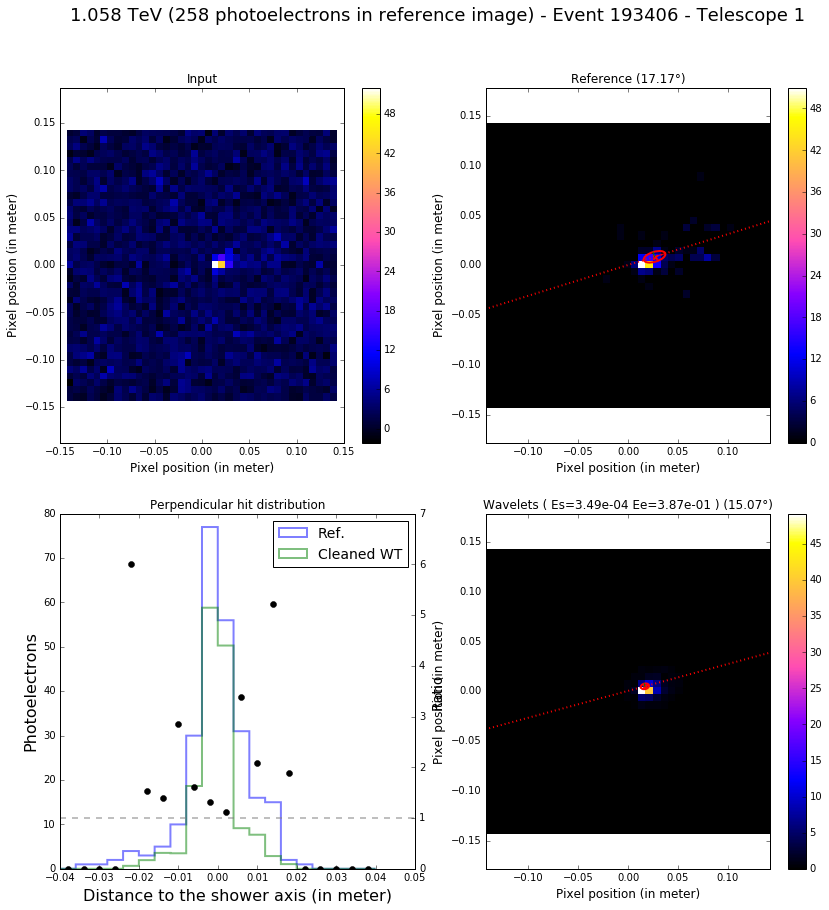

In [16]:
@interact(kill_pix=True, hist=False, log_scale=False, ellipses=True, lateral_hst=["Wavelet", "Tailcut", None], ref_angle=False, file_path=file_path_list, mrfilter="-K -C1 -m3 -s3 -n4")
def gui(kill_pix, hist, log_scale, ellipses, lateral_hst, ref_angle, file_path, mrfilter):
    fits_images_dict, fits_metadata_dict = datapipe.io.images.load_benchmark_images(file_path)
    input_img = fits_images_dict["input_image"]
    reference_img = fits_images_dict["reference_image"]
    pixels_position = fits_images_dict["pixels_position"]

    fig = plt.figure(figsize=(14, 14))

    common.plot_gui(fig,
                    input_img,
                    reference_img,
                    pixels_position,
                    fits_metadata_dict,
                    wavelets_cmd=mrfilter,
                    kill_isolated_pixels=kill_pix,
                    plot_histogram=hist,
                    plot_log_scale=log_scale,
                    plot_ellipse_shower=ellipses,
                    _plot_perpendicular_hit_distribution=lateral_hst,  # None, "Tailcut", "Wavelet"
                    use_ref_angle_for_perpendicular_hit_distribution=ref_angle,
                    notebook=True
                   )

### Threshold WT

* hard filter do 1, 0.6, ...

Idée: faire le contraire pourrait être pertinent dans notre cas, i.e. mettre un seuil plus bas pour les petites échelles (filtrer moins) et plus haut pour les grandes échelles (filtrer plus) pour conserver plus de détails (nos objets ne font que quelques pixels)

### Hexagonal images and corners

**Objectif n°1**: gérer les images ayant des "trous" dans les coins

Idée:
- pouvoir activer prématurement le "mirroring" d'un tuple de pixels (i.e. ce qui se passe quand on atteind le bord de l'image dans smooth_bspline) en mettant des pixels à une valeur particulière (FLOAT_MIN, NaN, ...)

<img src="./figs/geom_4_astri.png" width="40%">

**Objectif n°2**: travailler sur des images faites d'une grille de pixels hexagonaux

<img src="./figs/geom_3_flashcam.png" width="40%">

Idée:
    - ajouter une itération dans smooth_bspline: applique la convolution suivant un 3e axe
    - suppose de changer la structure de donnée des images (workaround de travailler avec des cubes)
    - l'idée n'est pas de changer la structure de donnée des images à un niveau global (imutilement long et compliqué) mais plutôt très localement pour une configuration particulière de filtre

<img src="./figs/hexagonal_grid.png" width="25%">

In [ ]:
# %load /Users/jdecock/bin/isap/cxx/sparse2d/src/libsparse2d/IM_Smooth.cc

void smooth_bspline (const Iint & Im_in,
                     Iint &Im_out,
                     type_border Type,
                     int Step_trou)
{
    int Nl = Im_in.nl();
    int Nc = Im_in.nc();
    int i,j,Step;
    float Coeff_h0 = 3. / 8.;
    float Coeff_h1 = 1. / 4.;
    float Coeff_h2 = 1. / 16.;
    Ifloat Buff(Nl,Nc,"Buff smooth_bspline");

    Step = (int)(pow((double)2., (double) Step_trou) + 0.5);

    for (i = 0; i < Nl; i ++)
    for (j = 0; j < Nc; j ++)
       Buff(i,j) = Coeff_h0 * (float)  Im_in(i,j)
                 + Coeff_h1 * (float) (  Im_in (i, j-Step, Type) 
                                       + Im_in (i, j+Step, Type)) 
                 + Coeff_h2 * (float) (  Im_in (i, j-2*Step, Type) 
                                       + Im_in (i, j+2*Step, Type));

    for (i = 0; i < Nl; i ++)
    for (j = 0; j < Nc; j ++)
       Im_out(i,j) = (int)(Coeff_h0 * Buff(i,j) +
                 + Coeff_h1 * (float) (  Buff (i-Step, j, Type) 
                                       + Buff (i+Step, j, Type)) 
                 + Coeff_h2 * (float) (  Buff (i-2*Step, j, Type) 
                                       + Buff (i+2*Step, j, Type)) + 0.5);

}

### Wrapper

Pour faire du filtrage en temps réel, l'utilisation de fichiers pour échanger les données avec mr_filter/mr_transform/... pose problème (temps d'accès aux fichiers trop long).

Idéalement il nous faudrait des wrappers Python.

Sinon, une amélioration possible peu couteuse en temps de developpement serait d'échanger les données via stdin/stdout.

### Autres idées

- ajouter une option -mX pour definir la "vraie" distribution du bruit de nos données 
- comme le signal est trés localisé, on pourrait envisager un algorithme en 2 passes qui ajusterait localement le poid des coefficients dans l'espace transformé après avoir localisé l'emplacement du signal
- une forme d'ondelette plus adaptée à ce type de signal (relativement régulier)
- learn the "optimal" mother wavelet from a set of pure signal

## Tool functions

### Afficher les informations d'un fichier fits

In [2]:
# %load /Users/jdecock/git/pub/jdhp/snippets/python/astropy/fits/print_infos.py
def fits_info(file_path):
    hdu_list = fits.open(file_path)
    hdu_list.info()
    hdu_list.close()

### Créer un fichier fits

In [3]:
# %load /Users/jdecock/git/pub/jdhp/snippets/python/astropy/fits/create_a_2d_fits_image_v2.py
def data_to_fits(img, file_path):
    hdu = fits.PrimaryHDU(img)
    hdu.writeto(file_path, clobber=True)

### Lire un fichier fits

In [4]:
def fits_to_data(file_path):
    hdu_list = fits.open(file_path) # Open the FITS file
    data = hdu_list[0].data
    hdu_list.close()                # Close the FITS file
    return data

### Charger un fichier fits mrfilter

In [5]:
def read_mr_file(file_path):
    hdu_list = fits.open(file_path) # Open the FITS file
    data = hdu_list[0].data
    hdu_list.close()                # Close the FITS file
    return data

### Charger un fichier fits sap-cta datapipe benchmark

In [2]:
def read_cta_file(file_path):
    hdu_list = fits.open(file_path) # Open the FITS file
    
    if (len(hdu_list) != 7) or (not hdu_list[0].is_image) or (not hdu_list[1].is_image) or (not hdu_list[2].is_image) or (not hdu_list[3].is_image) or (not hdu_list[4].is_image) or (not hdu_list[5].is_image) or (not hdu_list[6].is_image):
        hdu_list.close()
        raise Exception("Wrong file structure")

    hdu0, hdu1, hdu2, hdu3, hdu4, hdu5, hdu6 = hdu_list

    # IMAGES
    images_dict = {}
    
    images_dict["input_image"] = hdu0.data        # "hdu.data" is a Numpy Array
    images_dict["reference_image"] = hdu1.data    # "hdu.data" is a Numpy Array
    images_dict["adc_sum_image"] = hdu2.data      # "hdu.data" is a Numpy Array
    images_dict["pedestal_image"] = hdu3.data     # "hdu.data" is a Numpy Array
    images_dict["gains_image"] = hdu4.data        # "hdu.data" is a Numpy Array
    images_dict["calibration_image"] = hdu5.data  # "hdu.data" is a Numpy Array
    images_dict["pixels_position"] = hdu6.data    # "hdu.data" is a Numpy Array
    
    hdu_list.close()                # Close the FITS file
    
    return images_dict

### Plot

In [7]:
def plot(data, title="", log=False):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)

    ax1.set_title(title)
    
    if log:
        # See http://matplotlib.org/examples/pylab_examples/pcolor_log.html
        #     http://stackoverflow.com/questions/2546475/how-can-i-draw-a-log-normalized-imshow-plot-with-a-colorbar-representing-the-raw
        #im = ax1.pcolor(x, y, image_array, norm=LogNorm(vmin=0.01, vmax=image_array.max()), cmap=self.color_map)  # TODO: "vmin=0.01" is an arbitrary choice...
        im = ax1.imshow(data, interpolation='nearest', origin='lower', norm=LogNorm(vmin=0.01, vmax=data.max()), cmap="gnuplot2")   # cmap=cm.inferno and cmap="inferno" are both valid
    else:
        im = ax1.imshow(data, interpolation='nearest', origin='lower', cmap="gnuplot2")   # cmap=cm.inferno and cmap="inferno" are both valid
        #im = ax1.pcolor(x, y, image_array, cmap=self.color_map, vmin=z_min, vmax=z_max)

    plt.colorbar(im, ax=ax1)  # draw the colorbar
    
    #ax2 = fig.add_subplot(212)
    #ax2.hist(data)
    
    plt.show()

### Mr transform

In [9]:
# %load datapipe/denoising/wavelets_mrtransform.py

import datetime
import json
import os
import numpy as np
import time

from datapipe.io import images

def mr_transform(input_img, number_of_scales=4, base_file_path="wavelet_mrtransform", verbose=False):

    input_file_path = base_file_path + "_in.fits"
    mr_output_file_path = base_file_path + "_mr_planes.fits"

    # WRITE THE INPUT FILE (FITS) ##########################

    images.save(input_img, input_file_path)

    # EXECUTE MR_TRANSFORM #################################

    # TODO: improve the following lines
    cmd = 'mr_transform -n{} "{}" {}_out'.format(number_of_scales, input_file_path, base_file_path)
    os.system(cmd)

    # TODO: improve the following lines
    cmd = "mv {}_out.mr {}".format(base_file_path, mr_output_file_path)
    os.system(cmd)

    # READ THE MR_TRANSFORM OUTPUT FILE ####################

    output_imgs = images.load(mr_output_file_path, 0)

    if output_imgs.ndim != 3:
        raise Exception("Unexpected error: the output FITS file should contain a 3D array.")

    # DENOISE THE INPUT IMAGE WITH MR_TRANSFORM PLANES #####

    denoised_img = np.zeros(input_img.shape)

    for img_index, img in enumerate(output_imgs):

        if img_index < (len(output_imgs) - 1):  # All planes except the last one

            # Compute the standard deviation of the plane ##

            img_sigma = np.std(img)

            # Apply a threshold on the plane ###############

            # Remark: "abs(img) > (img_sigma * 3.)" should be the correct way to
            # make the image mask, but sometimes results looks better when all
            # negative coefficients are dropped ("img > (img_sigma * 3.)")

            #img_mask = abs(img) > (img_sigma * 3.)  
            img_mask = img > (img_sigma * 3.)
            cleaned_img = img * img_mask

            if verbose:
                images.plot(img, title="Plane {}".format(img_index))
                images.plot(img_mask, title="Binary mask for plane {}".format(img_index))
                images.plot(cleaned_img, title="Filtered plane {}".format(img_index))

            # Sum the plane ################################

            denoised_img = denoised_img + cleaned_img

        else:   # The last plane should be kept unmodified

            if verbose:
                images.plot(img, title="Plane {}".format(img_index))

            # Sum the last plane ###########################

            denoised_img = denoised_img + img

    return denoised_img

## Sandbox

### Plot a cta fits file

In [4]:
file_path = "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL001_EV00507.fits"

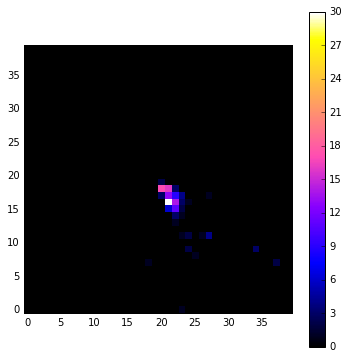

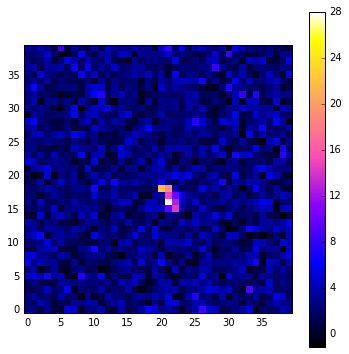

In [10]:
plot(read_cta_file(file_path)["reference_image"], log=False)
plot(read_cta_file(file_path)["input_image"], log=False)
#plot(read_cta_file(file_path)["adc_sum_image"][0])
#plot(read_cta_file(file_path)["calibration_image"][0])

In [ ]:
datapipe.io.images.plot(read_cta_file(file_path)["reference_image"])

In [ ]:
datapipe.io.images.plot_hist(read_cta_file(file_path)["reference_image"], logy=True)

### Run datapipe mrtransform cleaning

In [3]:
data = read_cta_file(file_path)["input_image"]

NameError: name 'file_path' is not defined

In [ ]:
out = mr_transform(data, verbose=True)
#plot(out)

### Run datapipe mrfilter cleaning

In [ ]:
cleaning_algorithm = mrfilter.WaveletTransform()

In [ ]:
data = read_cta_file(file_path)["input_image"]

In [ ]:
#cleaning_function_params = {
#                "type_of_multiresolution_transform": type_of_multiresolution_transform,
#                "type_of_filters": type_of_filters,
#                "type_of_non_orthog_filters": type_of_non_orthog_filters,
#                "number_of_scales": number_of_scales,
#                "suppress_last_scale": suppress_last_scale,
#                "suppress_isolated_pixels": suppress_isolated_pixels,
#                "kill_isolated_pixels": kill_isolated_pixels,
#                "coef_detection_method": coef_detection_method,
#                "k_sigma_noise_threshold": k_sigma_noise_threshold,
#                "noise_model": noise_model,
#                "detect_only_positive_structure": detect_only_positive_structure,
#                "suppress_positivity_constraint": suppress_positivity_constraint,
#                "type_of_filtering": type_of_filtering,
#                "first_detection_scale": first_detection_scale,
#                "number_of_iterations": number_of_iterations,
#                "epsilon": epsilon,
#                "support_file_name": support_file_name,
#                "precision": precision,
#                "offset_after_calibration": offset_after_calibration,
#                "correction_offset": correction_offset,
#                "input_image_scale": input_image_scale,
#                "verbose": verbose
#}

out = cleaning_algorithm.clean_image(data, raw_option_string="")

plot(data)
plot(out)

### Make a fits file for mr_filter

In [ ]:
data = read_cta_file(file_path)["input_image"]

data_to_fits(data, "test.fits")
plot(fits_to_data("test.fits"))

### Call mr_filter

In [ ]:
!mr_filter -h

In [ ]:
!mr_filter test.fits out.mr

fits_info("out.mr")
plot(read_mr_file("out.mr"))

### Call mr_filter and plot planes

In [ ]:
!mr_filter -w planes.mr -K -k -C1 -m3 -s3 -n4 test.fits out.mr

plot(read_mr_file("test.fits"))
plot(read_mr_file("out.mr"))

fits_info("planes.mr")

plot(read_mr_file("planes.mr")[0])
plot(read_mr_file("planes.mr")[1])
plot(read_mr_file("planes.mr")[2])
plot(read_mr_file("planes.mr")[3])